In [1]:
import torchvision
import torch
from torchinfo import summary
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# load a model, where the backbone is already trained, and the output layers aren't (at least, this should be the case...)
# also set the number of output classes to the number we need
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes, weights_backbone=True)

# load a model with fully pretrained weights
trained_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1)

# doesn't seem to work
#model.head.classification_head = new_model.head.classification_head


# freeze all layers, except the output heads
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True 

c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# print a model summary, to see the structure
# in the model with untrained heads, the number of parameters in the regression head is the same, 
# but the classification head drops from 1,286,604  (for 91 classes) to 64,104 (for 2 classes)

summary(model=model,   # can also look at "model=trained_model"
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
SSD (SSD)                                                              [32, 3, 224, 224]    [169, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)                                 [32, 3, 224, 224]    [32, 3, 320, 320]    --                   --
├─SSDLiteFeatureExtractorMobileNet (backbone)                          [32, 3, 320, 320]    [32, 128, 1, 1]      --                   False
│    └─Sequential (features)                                           --                   --                   --                   False
│    │    └─Sequential (0)                                             [32, 3, 320, 320]    [32, 672, 20, 20]    (869,096)            False
│    │    └─Sequential (1)                                             [32, 672, 20, 20]    [32, 960, 10, 10]    (2,102,856)          False
│    └─ModuleList

## See if the model actually functions

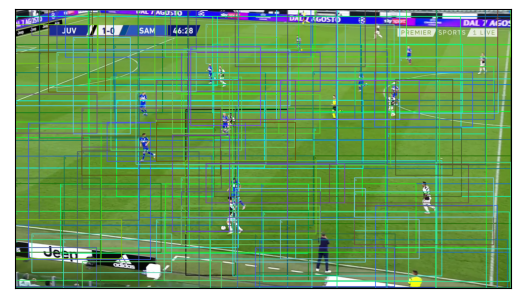

In [3]:
from torchvision.utils import draw_bounding_boxes, save_image
from torchvision.io import read_image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# load the image
convert_tensor = transforms.ToTensor()

image_path = "sample_75.jpg"
img = Image.open(image_path)

inputs = [convert_tensor(img)]

# prepare the model 
device = torch.device('cpu') # force CPU, for now
model.to(device)
model.eval()
output = model(inputs)



boxes = output[0]['boxes']
labels = output[0]['labels'].tolist()
labels = [str(i) for i in labels]

disp_image = read_image(image_path)
result = draw_bounding_boxes(disp_image, boxes, labels=labels, width=3)
show(result)

### see what the fully-pretrained one looks like

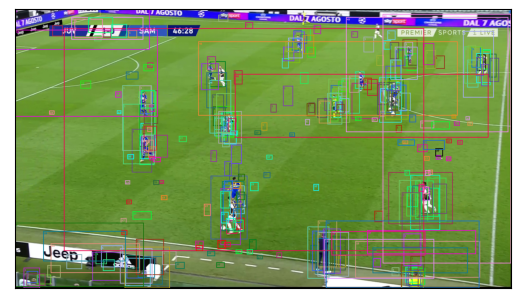

In [4]:
trained_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1)


# load the image
convert_tensor = transforms.ToTensor()

image_path = "sample_75.jpg"
img = Image.open(image_path)

inputs = [convert_tensor(img)]
    
# prepare the model 
device = torch.device('cpu') # force CPU, for now
trained_model.to(device)
trained_model.eval()
output = trained_model(inputs)

boxes = output[0]['boxes']
labels = output[0]['labels'].tolist()
labels = [str(i) for i in labels]

disp_image = read_image(image_path)
result = draw_bounding_boxes(disp_image, boxes, labels=labels, width=3)
show(result)


# Trying to load a dataset

In [7]:
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

# this is a class that loads the data, according to how pytorch wants it

class playersDataset(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.root = folder_path
        self.images_folder = os.path.join(folder_path, "images")
        self.labels_folder = os.path.join(folder_path, "annotations")
        
        self.image_files = os.listdir(self.images_folder)
        self.label_files = os.listdir(self.labels_folder)

        self.convert_tensor = transforms.ToTensor()
    """
    def loadData(self, path):
        image_files = os.listdir(self.images_folder)
        label_files = os.listdir(self.labels_folder)

        return image_files, label_files
    """

    def readLabelsFile(self, file_path, index):
        boxes = []
        labels = []
        areas = []

        with open(file_path) as f:
            for row in f:
                annotation = [float(x) for x in row.split()]
                #print(annotation)
                labels.append(int(annotation[0]))
                [x0, y0, x1, y1] = annotation[1:5]
                boxes.append([x0, y0, x1, y1])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)         
        labels = torch.as_tensor(labels, dtype=torch.int64)

        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {
            "boxes" : boxes,
            "labels" : labels,
            "image_id" : torch.tensor(index),
            "area" : areas,
            "iscrowd" : iscrowd
            }

        return target


    # pytorch needs this, it returns a single (image, output) pair
    def __getitem__(self, index):
        # load and format the image file as a tensor
        
        imgPath = os.path.join(self.images_folder, self.image_files[index])
        img = Image.open(imgPath)

        # TEMPORARY - REMOVE THIS LATER, WE SHOULD DECIDE HOW LARGE THE IMAGES ARE
        img = img.resize((1080, 1920))

        input_img = self.convert_tensor(img)

        # load and format the corresponding labels
        labelPath = os.path.join(self.labels_folder, self.label_files[index])
        target = self.readLabelsFile(labelPath, index)
        
        return input_img, target

    # pytorch also needs the length of the dataset
    def __len__(self):
        return len(self.image_files)
    


In [8]:
import torchvision
import torch
from torchinfo import summary
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

# load a model, where the backbone is already trained, and the output layers aren't (at least, this should be the case...)
# also set the number of output classes to the number we need
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes, weights_backbone=True)



def collate_fn(batch):
    return tuple(zip(*batch))


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_workers = 1 if torch.cuda.is_available() else 0

train_dataset = playersDataset("SOD_Dataset")
train_dataloader = DataLoader(train_dataset,  batch_size=16, shuffle=True, num_workers=0,  collate_fn=collate_fn)

c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


num_epochs = 1

dataset_size = len(train_dataset.image_files)

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            print("TRAIN")
        else:
            model.eval()   # Set model to evaluate mode
            print("EVAL")

        running_loss = 0.0
        running_corrects = 0

        
        # Iterate over data.
        for i, (images, targets) in enumerate(train_dataloader):

            # zero the parameter gradients
            optimizer.zero_grad()

            # send both the input images and output targets to the device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                loss_dict = model(images, targets) 
                print(loss_dict)
                losses = sum(loss for loss in loss_dict.values())  # sum the loss for all images of this epoch

                print(losses)
                running_loss += float(losses)
                print(running_loss)


                # backward + optimize only if in training phase
                if phase == 'train':
                    losses.backward()
                    optimizer.step()


        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_size
        #epoch_acc = running_corrects.double() / dataset_size

Epoch 0/0
----------
TRAIN
{'bbox_regression': tensor(5.5312, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(0.1704, device='cuda:0', grad_fn=<DivBackward0>)}
tensor(5.7016, device='cuda:0', grad_fn=<AddBackward0>)
5.701630592346191
{'bbox_regression': tensor(5.4059, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(0.1515, device='cuda:0', grad_fn=<DivBackward0>)}
tensor(5.5574, device='cuda:0', grad_fn=<AddBackward0>)
11.259039878845215
{'bbox_regression': tensor(4.9948, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(0.2397, device='cuda:0', grad_fn=<DivBackward0>)}
tensor(5.2345, device='cuda:0', grad_fn=<AddBackward0>)
16.493540287017822
{'bbox_regression': tensor(5.7730, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(0.1484, device='cuda:0', grad_fn=<DivBackward0>)}
tensor(5.9214, device='cuda:0', grad_fn=<AddBackward0>)
22.414964199066162
{'bbox_regression': tensor(5.3848, device='cuda:0', grad_fn=<DivBa

AttributeError: 'list' object has no attribute 'values'